  ### **Final Project**: Baseball Optics Analysis - Exploratory Data Analysis
   - Name: Andrew Lang, Joseph Oladeji, Richard Prange
   - Class Name: MATH475 - Statistical Machine Learning

The **Track_Combo.csv** dataset contains **3,344** observations with **141 columns** from 21 different scrimmages. It includes detailed pitch-level data from college baseball scrimmages, recorded by TrackMan V3. The dataset also captures various pitch characteristics, such as the pitcher's and batter's information, pitch speed, trajectory, and confidence metrics as well as both numerical and categorical fields, and includes confidence ratings on certain metrics.

We are interested in called balls and strikes. Thus to do this we will go through a proces of eliminating pictches and columns not needed for our classification needs.

Reference:

Pifer, N. D. P. (2024, September 16). Optical tracking data from college baseball scrimmages. Mendeley Data. https://data.mendeley.com/datasets/xfnz6mkdzm/3

In [1]:
# Remove unessicary columns before eda

import pandas as pd

# Read the data
baseball_data = pd.read_csv("Track_Combo.csv")
cols_to_not_drop = ["PitchCall", "PlateLocHeight", "PlateLocSide"]


# remove all of the colums that dont pertain to the outcome of the pitch and its location
classification_needs = baseball_data[cols_to_not_drop]
#print(classification_needs)

# Removing the un needed pitch calls
# We dont want foul ball, strike swinging, etc as the location of those pitches may throw the model off
df_filtered = classification_needs[classification_needs["PitchCall"].isin(['StrikeCalled', 'BallCalled'])]

# remove two rows with null entries
df_filt_no_null = df_filtered.dropna()


print(df_filt_no_null.head())
print(df_filt_no_null.shape)



       PitchCall  PlateLocHeight  PlateLocSide
2   StrikeCalled         2.30084      -0.80157
4     BallCalled         2.89414      -1.49088
10    BallCalled         1.00717      -0.16006
13    BallCalled         0.34854      -2.32798
15    BallCalled         0.70726      -2.10070
(1854, 3)


# Define the area of the strike zone and remove outliers.

In [9]:
# in this section I want to remove pitches that were above 5 ft and below 0ft in height

# Strike Zone
UPPER = 3.3773
LOWER = 1.5
SIDE = .83083

# Define the coordinates for the box (xmin, ymin, width, height)
xmin = -1 * SIDE  # value for the lower left x-coordinate of the box
ymin = LOWER  # value for the lower left y-coordinate of the box
width = 2 * SIDE # Width of the box
height = UPPER - LOWER # Height of the box


# Remove all entries in the height column greater than 5 or less than equal to 0
df_filtered = df_filt_no_null[df_filt_no_null['PlateLocHeight'] >= 0]
df_filtered = df_filtered[df_filtered['PlateLocHeight'] < 5]


print(df_filtered.shape)






(1777, 3)


We removed around 80 entries with unsatisfactory heights.



In [13]:
remove_false_call()

# Plotting
Below is some code to plot some of the pitches, added a "strike-zone" in
the picture.


In [14]:
#plotting some of the entries
import matplotlib.pyplot as plt
import io
from PIL import Image

## List to store the images
image_list = []


# Get the global min and max for PlateLocSide and PlateLocHeight
x_min = df_filtered['PlateLocSide'].min() + .2
x_max = df_filtered['PlateLocSide'].max() + .2
y_min = df_filtered['PlateLocHeight'].min() + .2
y_max = df_filtered['PlateLocHeight'].max() + .2



# Create scatter plots one by one, plotting only a single entry per plot
#for i in range(len(df_filtered)):
for i in range(0, 5):
    # Get the specific entry to plot (single row)
    entry = df_filtered.iloc[i]

    # Create a new figure for each plot
    plt.figure(figsize=(8, 6))

    # Plot just the single entry (PlateLocSide, PlateLocHeight)
    plt.scatter(entry['PlateLocSide'], entry['PlateLocHeight'], color='blue', s=100, edgecolors='k', label=f'Entry {i+1}')

    # Create the rectangle (box) and add it to the plot
    box = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='orange', facecolor='none', linestyle='solid')
    plt.gca().add_patch(box)

    # Set axis limits to ensure consistent plot size
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Add titles and labels
    plt.title(f'Scatter Plot with Box - Entry {i+1} with result {entry["PitchCall"]}', fontsize=14)
    plt.xlabel('PlateLocSide', fontsize=12)
    plt.ylabel('PlateLocHeight', fontsize=12)

    # Save the plot to a BytesIO object (in-memory image)
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)

    # Open the image from the buffer and append to the list
    img = Image.open(img_buffer)
    image_list.append(img)

    # Close the plot to avoid overlapping
    plt.close()



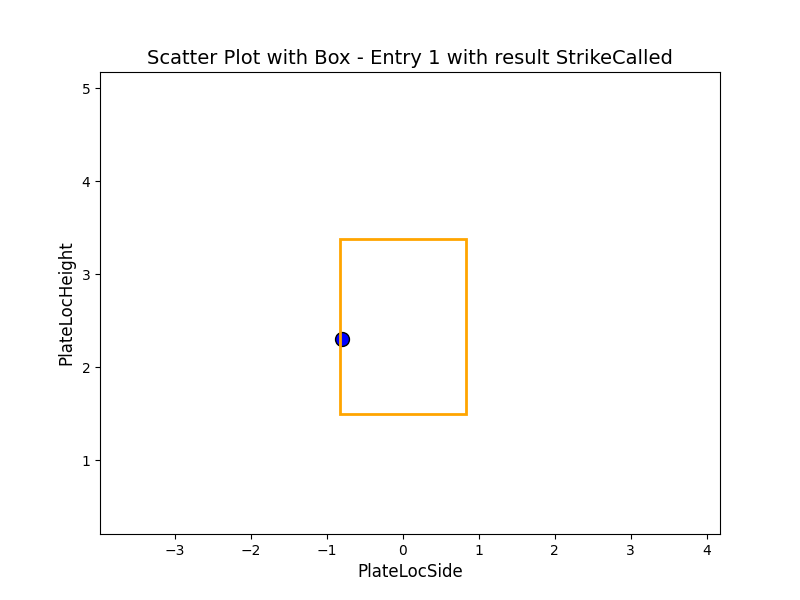

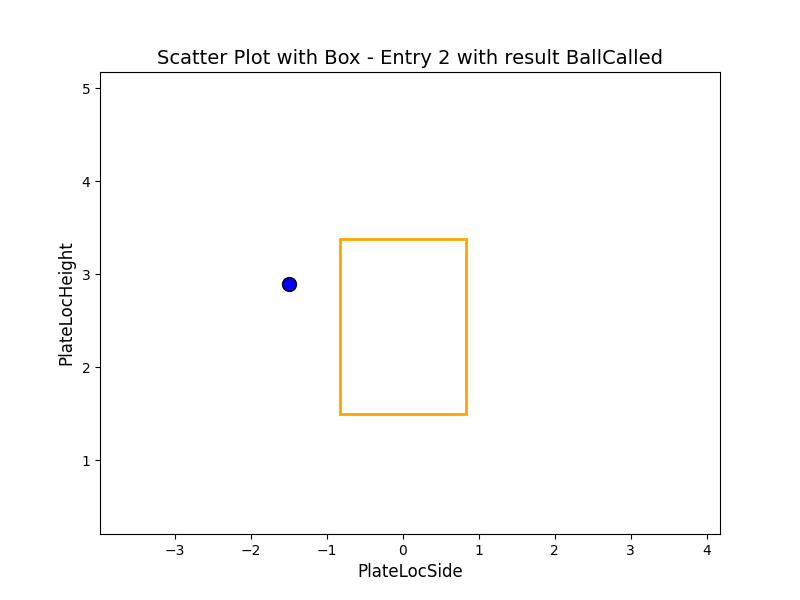

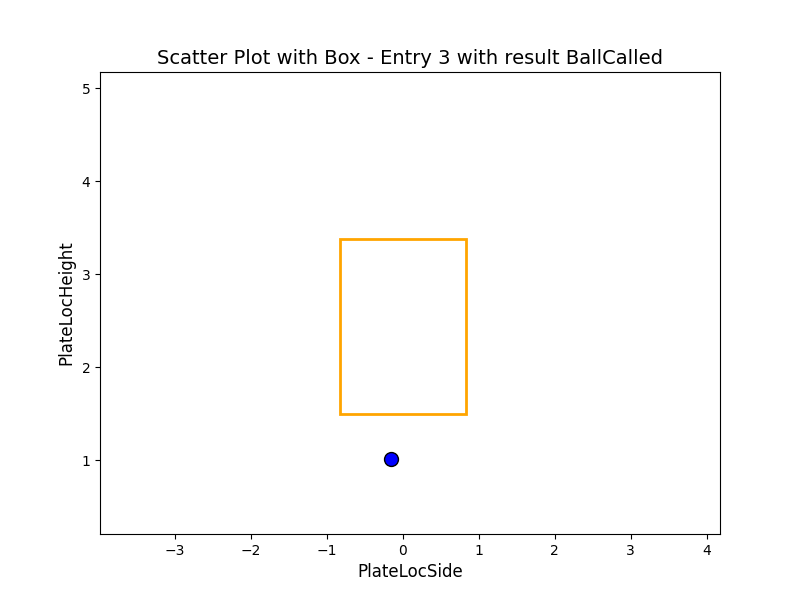

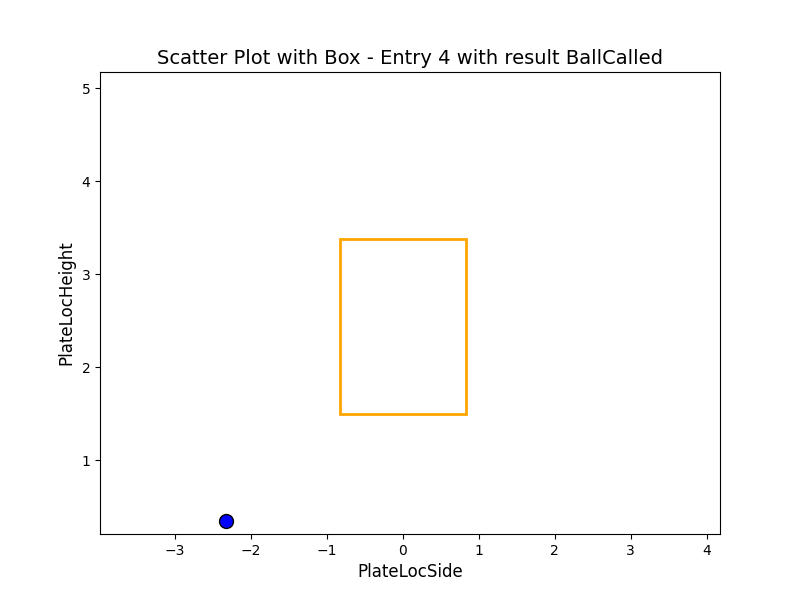

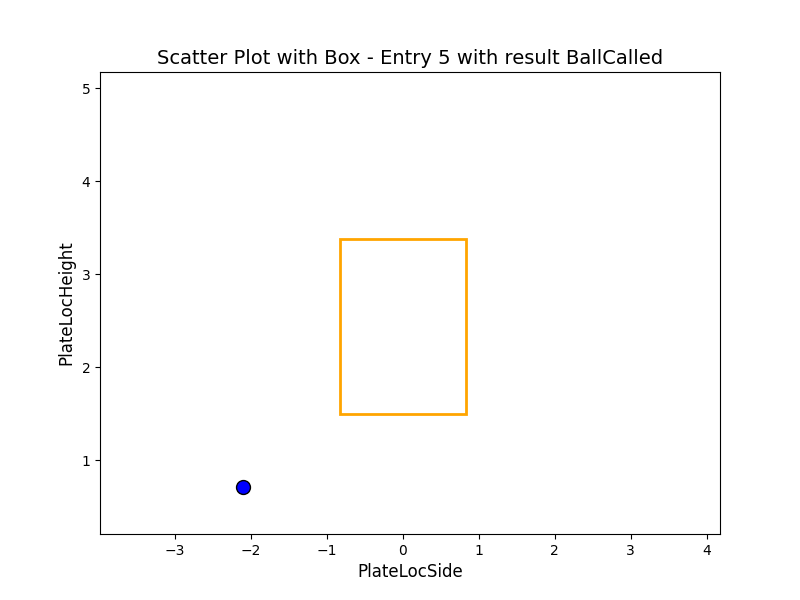

In [15]:
for im in image_list[0:5]:
    display(im)

# Removing False Calls
In the following cell we will write some code to remove false balls and false strikes.

I.e if in the picture the ball is inside the strikezone but called a ball it will be removed, along with strikes called balls.

In [12]:


def remove_false_call():
    global df_filtered  # Declare df_filtered as global

    i = 0  # Initialize an index counter
    while i < len(df_filtered):
        entry = df_filtered.iloc[i]

        if entry['PitchCall'] == 'BallCalled':
            # If it's a ball but inside the strike zone, remove it
            if in_range(xmin, xmin + width, entry['PlateLocSide']) and in_range(ymin, ymin + height, entry['PlateLocHeight']):
                df_filtered = df_filtered.drop(df_filtered.index[i])
                df_filtered.reset_index(drop=True, inplace=True)  # Reset index after drop
                continue  # Skip incrementing i because the dataset has shifted
        else:
            # If it's a strike but outside the strike zone, remove it
            if not in_range(xmin, xmin + width, entry['PlateLocSide']) or not in_range(ymin, ymin + height, entry['PlateLocHeight']):
                df_filtered = df_filtered.drop(df_filtered.index[i])
                df_filtered.reset_index(drop=True, inplace=True)  # Reset index after drop
                continue  # Skip incrementing i because the dataset has shifted

        i += 1  # Increment the index only if no rows were dropped


def in_range(lower,upper,val) -> bool:
  return lower <= val <= upper




### **Handling Missing Values**

In [ ]:
# # Replace missing values with the median for numerical features
# numerical_features = baseball_data.select_dtypes(include='number').columns
# baseball_data[numerical_features] = baseball_data[numerical_features].fillna(baseball_data[numerical_features].median())

# # Replace missing values with the mode for categorical features
# categorical_features = baseball_data.select_dtypes(include='object').columns
# baseball_data[categorical_features] = baseball_data[categorical_features].fillna(baseball_data[categorical_features].mode().iloc[0])


# Define a custom Winsorized median imputation function,
# istead of directly using the median, use a Winsorized median to limit the
# influence of extreme outliers on the imputation.
def winsorized_median_impute(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return column.clip(lower_bound, upper_bound).median()

# Apply the Winsorized median imputation to numerical features
numerical_features = baseball_data.select_dtypes(include='number').columns
for feature in numerical_features:
    median_value = winsorized_median_impute(baseball_data[feature].dropna())
    baseball_data[feature] = baseball_data[feature].fillna(median_value)


1. **Identifying Missing Values**:
   - Upon examining the dataset, we observed that several columns contain missing values. Here are some notable columns and the percentage of missing values:
     - `AutoHitType`: 81.85% missing
     - `HitLaunchConfidence`: 75.66% missing
     - `CatcherThrowCatchConfidence`: 96.47% missing
     - `RelSpeed` (Release Speed): 0.15% missing
     - `VertRelAngle` and `HorzRelAngle` (Angles of Release): 0.15% missing
   - Columns with substantial gaps, such as `CatcherThrowCatchConfidence` and `AutoHitType`, require careful consideration, as their high missing values may indicate either optional data or less reliable fields. Identifying these missing values early guided our approach to handle them effectively.

2. **Filling Missing Values**:
   - **Numerical Features**: For numerical columns, including `RelSpeed`, `VertRelAngle`, and `HorzRelAngle`, we replaced missing values with the **median** of each column. This approach minimizes the impact of outliers on the data’s central tendency.
   - **Categorical Features**: For categorical columns, such as `AutoPitchType` and `AutoHitType`, we filled missing values using the **mode** (most frequent value) for each feature. Filling with the mode helps preserve the integrity of categorical data by aligning filled values with the most common entries.

3. **Impact on Data Quality**:
   - By addressing missing values, we created a more complete dataset, reducing biases that could arise from leaving gaps or removing rows with missing data.
   - This approach ensures the dataset's consistency, which helps maintain its overall distribution and supports accurate model training.

This strategy enables robust modeling by reducing information loss while maintaining the dataset's structure and distribution.


### **Identify Numerical & Categorical Features and Identify/Plot Outliers**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying the numerical features
numer_feats = baseball_data.select_dtypes(include=['float64', 'int64']).columns
print("Numerical features: ", numer_feats)

# Identifying the categorial features
categorical_feats = baseball_data.select_dtypes(include=['object']).columns
print("\nCategorical features:", categorical_feats)

# Relationship between Pitch Call and Release Speed to identify outliers
plt.figure(figsize=(12, 8))
plt.title("Release Speed vs Pitch Call")
sns.boxplot(x=baseball_data['PitchCall'], y=baseball_data['RelSpeed'])
plt.xlabel("Pitch Call")
plt.ylabel("Release Speed (mph)")
plt.show()

# Relationship between Release Speed and Spin Rate to find speed-spin outliers
plt.figure(figsize=(10, 10))
plt.title("Release Speed vs Spin Rate")
sns.scatterplot(x=baseball_data['RelSpeed'], y=baseball_data['SpinRate'])
plt.xlabel("Release Speed (mph)")
plt.ylabel("Spin Rate (rpm)")
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

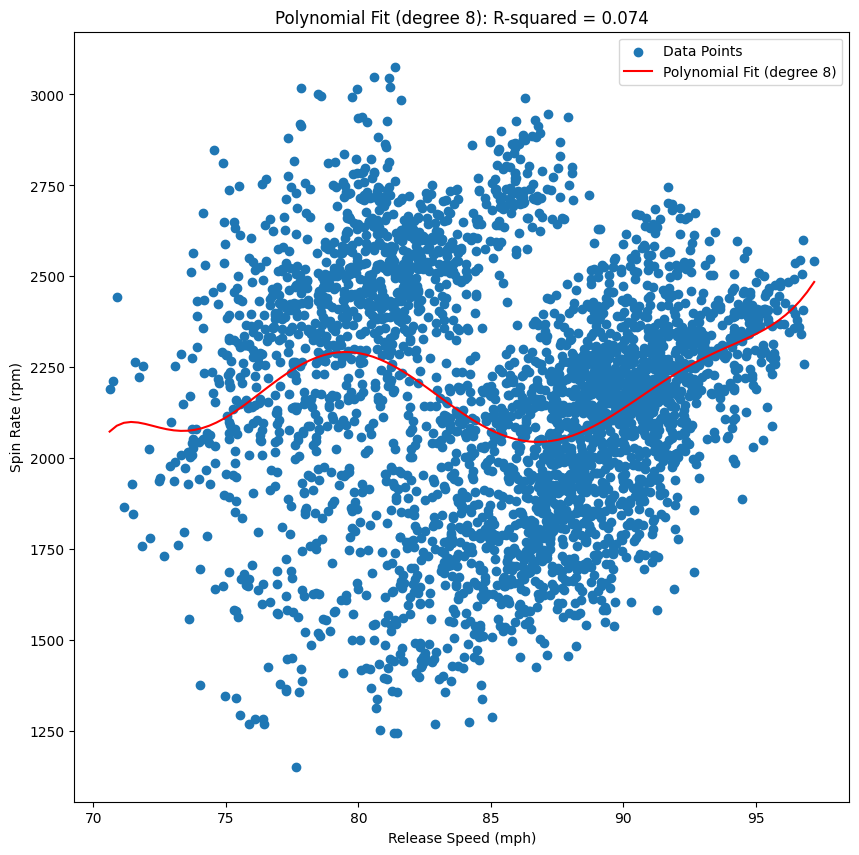

R-squared for polynomial fit (degree 8): 0.07377753961156508


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Filter data to only include RelSpeed between 70 and 105
filtered_data = baseball_data[(baseball_data['RelSpeed'] >= 70) & (baseball_data['RelSpeed'] <= 105)]
x = filtered_data['RelSpeed']
y = filtered_data['SpinRate']

# Fit a polynomial model (e.g., cubic polynomial of degree 3)
degree = 8  # Change this degree based on the desired complexity
coefficients = np.polyfit(x, y, degree)

# Generate y values using the fitted polynomial model
x_fit = np.linspace(min(x), max(x), 100)  # Generate x values for smooth plotting
y_fit = np.polyval(coefficients, x_fit)

# Calculate R-squared for the fit
y_pred = np.polyval(coefficients, x)
r_squared = r2_score(y, y_pred)

# Plot the data and the polynomial fit
plt.figure(figsize=(10, 10))
plt.scatter(x, y, label="Data Points")
plt.plot(x_fit, y_fit, color="red", label=f"Polynomial Fit (degree {degree})")
plt.xlabel("Release Speed (mph)")
plt.ylabel("Spin Rate (rpm)")
plt.title(f"Polynomial Fit (degree {degree}): R-squared = {r_squared:.3f}")
plt.legend()
plt.show()

print(f"R-squared for polynomial fit (degree {degree}):", r_squared)






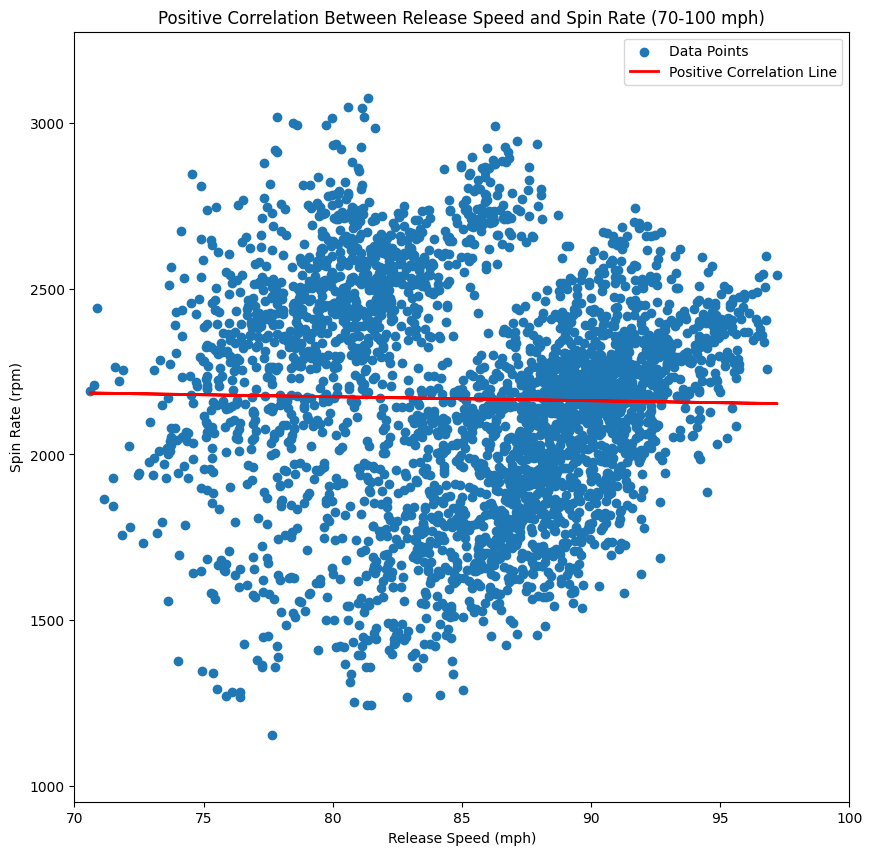

In [ ]:
# Adjusting the x and y ranges to highlight any positive correlation between Release Speed and Spin Rate

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Filter the data to only include Release Speed between 70 and 100
x_filtered = baseball_data['RelSpeed'][(baseball_data['RelSpeed'] >= 70) & (baseball_data['RelSpeed'] <= 100)]
y_filtered = baseball_data['SpinRate'][(baseball_data['RelSpeed'] >= 70) & (baseball_data['RelSpeed'] <= 100)]

# Fit a linear regression model to capture the positive correlation
x_reshaped = x_filtered.values.reshape(-1, 1)
model = LinearRegression()
model.fit(x_reshaped, y_filtered)

# Define the line for positive correlation
slope = model.coef_[0]
intercept = model.intercept_

# Scatter plot with adjusted x and y limits to emphasize correlation
plt.figure(figsize=(10, 10))
plt.scatter(x_filtered, y_filtered, label="Data Points")
plt.plot(x_filtered, slope * x_filtered + intercept, color="red", label="Positive Correlation Line", linewidth=2)

# Resize x and y ranges to highlight the trend
plt.xlim(70, 100)
plt.ylim(y_filtered.min() - 200, y_filtered.max() + 200)

plt.xlabel("Release Speed (mph)")
plt.ylabel("Spin Rate (rpm)")
plt.title("Positive Correlation Between Release Speed and Spin Rate (70-100 mph)")
plt.legend()
plt.show()


In [ ]:
# Outlier boundaries for 'RelSpeed'
Q1_speed = baseball_data['RelSpeed'].quantile(0.25)
Q3_speed = baseball_data['RelSpeed'].quantile(0.75)
IQR_speed = Q3_speed - Q1_speed
outliers_speed = baseball_data[(baseball_data['RelSpeed'] < (Q1_speed - 1.5 * IQR_speed)) |
                               (baseball_data['RelSpeed'] > (Q3_speed + 1.5 * IQR_speed))]

# Outlier boundaries for 'SpinRate'
Q1_spin = baseball_data['SpinRate'].quantile(0.25)
Q3_spin = baseball_data['SpinRate'].quantile(0.75)
IQR_spin = Q3_spin - Q1_spin
outliers_spin = baseball_data[(baseball_data['SpinRate'] < (Q1_spin - 1.5 * IQR_spin)) |
                              (baseball_data['SpinRate'] > (Q3_spin + 1.5 * IQR_spin))]

# Displaying the outliers for 'RelSpeed' and 'SpinRate'
outliers_speed[['PitchCall', 'RelSpeed']], outliers_spin[['PitchCall', 'SpinRate']]

(         PitchCall  RelSpeed
 139         InPlay  66.84434
 149     BallCalled  67.79554
 169   StrikeCalled  67.65674
 668         InPlay  67.75993
 1463    BallCalled  64.90804
 1470  StrikeCalled  64.80482
 1472      FoulBall  63.91192
 1475    BallCalled  65.49647
 1476    BallCalled  65.37575
 1477  StrikeCalled  65.34939
 1478    BallCalled  64.33914
 1480    BallCalled  63.55759
 2054  StrikeCalled  65.09497
 2056    HitByPitch  65.31251
 2082  StrikeCalled  66.97812
 2083  StrikeCalled  66.44838
 2084    BallCalled  65.45545
 2086    BallCalled  65.00188
 2087    BallCalled  64.20662
 2088    BallCalled  65.07344
 2093    BallCalled  67.04378
 2095        InPlay  66.66652
 2333  StrikeCalled  66.90871
 2336    BallCalled  65.46383
 2338    HitByPitch  66.75317
 2343  StrikeCalled  66.33810
 2346        InPlay  65.93267
 2348      FoulBall  65.35889
 2349    BallCalled  62.65272
 2351        InPlay  65.46431
 2528    BallCalled  66.68877
 2530    BallCalled  67.43543
 2531    B

### 1. Visual Analysis with Boxplots and Scatterplots
- **Boxplot of Release Speed vs. Pitch Call**: We created a boxplot comparing `PitchCall` with `RelSpeed` (release speed) to detect any speed outliers across different pitch types. This visualization helps spot if certain pitch types have speeds that deviate significantly from the average, which could be outliers.
- **Scatterplot of Release Speed vs. Spin Rate**: We also created a scatterplot of `RelSpeed` against `SpinRate`, as unusual combinations of these two metrics could signal anomalies in pitch characteristics.

### 2. Statistical Identification Using the IQR Method
- We used the **Interquartile Range (IQR) method** to pinpoint outliers in `RelSpeed` and `SpinRate`. The IQR method identifies values as outliers if they fall outside the range of `Q1 - 1.5 * IQR` to `Q3 + 1.5 * IQR`. Specifically:
  - **Release Speed Outliers**: Observations in `RelSpeed` that are either significantly lower or higher than the majority, indicating abnormal pitch speeds.
  - **Spin Rate Outliers**: Similar boundaries were calculated for `SpinRate`, helping to detect pitches with atypical spin rates.

This combination of boxplots, scatterplots, and the IQR method provides a thorough approach to identifying outliers in key metrics like pitch speed and spin rate. These outliers can then be addressed during preprocessing—either by transforming, removing, or handling them in a way that maintains the integrity of the dataset for subsequent analysis and model training.



In [ ]:
import pandas as pd

# Identify categorical features
categorical_features = baseball_data.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical features
encoded_data = pd.get_dummies(baseball_data, columns=categorical_features, drop_first=True)

# Display the first few rows to verify encoding
encoded_data.head()

,PitchNo,PAofInning,PitchofPA,PitcherId,BatterId,Inning,Outs,Balls,Strikes,OutsOnPlay,...,PitchMovementConfidence_Low,PitchMovementConfidence_Medium,HitLaunchConfidence_High,HitLaunchConfidence_Low,HitLaunchConfidence_Medium,HitLandingConfidence_High,HitLandingConfidence_Low,HitLandingConfidence_Medium,CatcherThrowReleaseConfidence_Medium,CatcherThrowLocationConfidence_Medium
0,1,1,1,1000036206,1000102964,1,0,0,0,1,...,False,False,True,False,False,True,False,False,False,False
1,2,2,1,1000036206,8886045,1,1,0,0,0,...,False,False,True,False,False,False,True,False,False,False
2,3,3,1,1000036206,1000103136,1,1,0,0,0,...,False,False,True,False,False,False,True,False,False,False
3,4,3,2,1000036206,1000103136,1,1,0,1,0,...,False,False,True,False,False,False,True,False,False,False
4,5,3,3,1000036206,1000103136,1,1,0,2,0,...,False,False,True,False,False,False,True,False,False,False


For categorical variables with a small number of unique values (e.g., `PitchCall`, `BatterSide`, `PitcherThrows`), we use one-hot encoding to convert them into binary columns. This approach transforms each category into its own binary column (0 or 1), indicating the presence of a particular category.


### **Feature Scaling: Standardization**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical features related to pitch metrics for scaling
pitch_metrics = ['RelSpeed', 'SpinRate', 'VertRelAngle', 'HorzRelAngle', 'RelHeight']

# Applying standardization (z-score scaling) to these selected pitch metrics
scaler = StandardScaler()
baseball_data[pitch_metrics] = scaler.fit_transform(baseball_data[pitch_metrics])

# Displaying the first few rows of the dataset to verify scaling
baseball_data[pitch_metrics].head()


,RelSpeed,SpinRate,VertRelAngle,HorzRelAngle,RelHeight
0,-0.835390,0.874854,0.650416,-0.050051,-0.436279
1,0.881099,0.292997,-0.690218,-0.318671,-0.474072
2,-1.250311,0.785012,1.261462,-0.028305,-0.334317
3,0.373134,0.132908,-0.249564,-1.058377,-0.420897
4,0.616285,0.086109,0.309184,-1.279866,-0.549294


In [ ]:
import pandas as pd

# Read the data
baseball_data = pd.read_csv("Track_Combo.csv")

# Displaying dataset dimensions and types for each column
print("Dimensions of the Dataset:", baseball_data.shape)
print("\nFeature Names and Types:\n", baseball_data.dtypes)

# Displaying the first few rows of the dataset
display_head = baseball_data.head()

# Checking for missing values and calculating the percentage
missing_values = baseball_data.isnull().sum()
percent_missing = (missing_values / len(baseball_data)) * 100
missing_data_summary = percent_missing[percent_missing > 0]

# Displaying columns with missing values and their percentage
print("\nColumns with Missing Values and Percentage:\n", missing_data_summary)

# TODO: IDENTIFY HIGHLY CORRELATED FEATURES

display_head, missing_data_summary


Dimensions of the Dataset: (3344, 141)

Feature Names and Types:
 PitchNo                            int64
Date                              object
PAofInning                         int64
PitchofPA                          int64
PitcherId                          int64
                                   ...  
HitLandingConfidence              object
CatcherThrowCatchConfidence       object
CatcherThrowReleaseConfidence     object
CatcherThrowLocationConfidence    object
System                            object
Length: 141, dtype: object

Columns with Missing Values and Percentage:
 AutoPitchType                      0.179426
AutoHitType                       81.848086
RelSpeed                           0.149522
VertRelAngle                       0.149522
HorzRelAngle                       0.149522
                                    ...    
HitLaunchConfidence               75.657895
HitLandingConfidence              75.657895
CatcherThrowCatchConfidence       96.471292
CatcherThrowRe

(   PitchNo      Date  PAofInning  PitchofPA   PitcherId PitcherThrows  \
 0        1  2/9/2023           1          1  1000036206         Right   
 1        2  2/9/2023           2          1  1000036206         Right   
 2        3  2/9/2023           3          1  1000036206         Right   
 3        4  2/9/2023           3          2  1000036206         Right   
 4        5  2/9/2023           3          3  1000036206         Right   
 
   PitcherTeam    BatterId BatterSide BatterTeam  ...  ThrowTrajectoryZc2  \
 0         T_A  1000102964      Right        T_B  ...                 NaN   
 1         T_A     8886045       Left        T_B  ...                 NaN   
 2         T_A  1000103136      Right        T_B  ...                 NaN   
 3         T_A  1000103136      Right        T_B  ...                 NaN   
 4         T_A  1000103136      Right        T_B  ...                 NaN   
 
   PitchReleaseConfidence  PitchLocationConfidence  PitchMovementConfidence  \
 0         